In [1]:
from mssm.models import *
from mssm.src.python.compare import compare_CDL
from mssmViz.sim import *
from mssmViz.plot import *
import numpy as np
import scipy as scp
from matplotlib import pyplot as plt

import sys
import os
import inspect

SCRIPT_DIR = "./../tests"
sys.path.append(os.path.dirname(SCRIPT_DIR))

from tests.defaults import default_gamm_test_kwargs,default_gammlss_test_kwargs,default_gsmm_test_kwargs,default_compare_test_kwargs

size_conv = 2.54
single_width = 6/size_conv
double_width = 12/size_conv
full_width = 19/size_conv

plt.rcParams["font.size"] = 8
plt.rcParams["axes.titlesize"] = 9.5
plt.rcParams["axes.labelsize"] = 8
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8
plt.rcParams["legend.fontsize"] = 8
plt.rcParams["figure.titlesize"] = 11

Acc (UC, WPS).: [np.float64(0.26), np.float64(0.22)]: 100%|██████████| 100/100 [02:11<00:00,  1.31s/it]
Acc (UC, WPS).: [np.float64(0.32), np.float64(0.23)]: 100%|██████████| 100/100 [02:10<00:00,  1.30s/it]
Acc (UC, WPS).: [np.float64(0.55), np.float64(0.42)]: 100%|██████████| 100/100 [02:10<00:00,  1.31s/it]
Acc (UC, WPS).: [np.float64(0.81), np.float64(0.68)]: 100%|██████████| 100/100 [02:09<00:00,  1.30s/it]
Acc (UC, WPS).: [np.float64(0.9), np.float64(0.88)]: 100%|██████████| 100/100 [02:08<00:00,  1.29s/it]
Acc (UC, WPS).: [np.float64(0.97), np.float64(0.97)]: 100%|██████████| 100/100 [02:08<00:00,  1.29s/it]
Acc (UC, WPS).: [np.float64(1.0), np.float64(0.99)]: 100%|██████████| 100/100 [02:09<00:00,  1.30s/it]
Acc (UC, WPS).: [np.float64(1.0), np.float64(1.0)]: 100%|██████████| 100/100 [02:09<00:00,  1.29s/it]
Acc (UC, WPS).: [np.float64(1.0), np.float64(1.0)]: 100%|██████████| 100/100 [02:09<00:00,  1.29s/it]
Acc (UC, WPS).: [np.float64(1.0), np.float64(1.0)]: 100%|██████████| 1

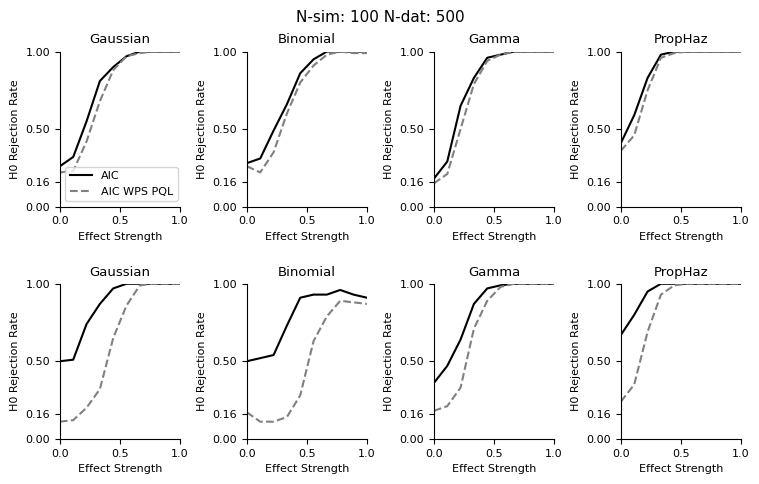

In [ ]:
test_kwargs = copy.deepcopy(default_gamm_test_kwargs)
test_kwargs_gsmm = copy.deepcopy(default_gsmm_test_kwargs)
test_kwargs["progress_bar"] = False
test_kwargs["max_outer"] = 500
test_kwargs["max_inner"] = 1
test_kwargs["extend_lambda"] = False

test_kwargs_gsmm["progress_bar"] = False
test_kwargs_gsmm["max_outer"] = 200
test_kwargs_gsmm["max_inner"] = 500
test_kwargs_gsmm["extend_lambda"] = False
test_kwargs_gsmm["repara"] = True
test_kwargs_gsmm["control_lambda"] = 2

fig = plt.figure(figsize=(full_width,2*single_width),layout='constrained')
axs = fig.subplots(2,4,gridspec_kw=dict(wspace=0.01,hspace=0.1))
axs = axs.flatten()

n_c = 10
n_sim = 100
n_dat = 500
df = 40
nR = 250
n_cores = 4

families = ["Gaussian","Binomial","Gamma","PropHaz"]
binom_offsets = [0,-5,0,0.1]
scales = [2,2,2,2]

######################################## Smooth Selection ########################################

for fi,(family,binom_offset,scale) in enumerate(zip(families,binom_offsets,scales)):

    AIC_rej = np.zeros(n_c)

    # WPS-like
    WPS_AIC_PQL_rej = np.zeros(n_c)

    for c_i,c_val in enumerate(np.linspace(0,1,n_c)):

        iterator = tqdm(range(n_sim),desc="Simulating",leave=True)
        for sim_i in iterator:

            ######################################## Family setup ########################################
            mod_fam = Gaussian()
            if family == "Binomial":
                mod_fam = Binomial()
            if family == "Gamma":
                mod_fam = Gamma()

            mod_fam.is_canonical = True
            
            ######################################## Create Data ########################################
            if family == "PropHaz":
                sim_fit_dat = sim3(n=n_dat,scale=scale,c=c_val,family=PropHaz([0],[0]),binom_offset=binom_offset,seed=sim_i)
                sim_fit_dat = sim_fit_dat.sort_values(['y'],ascending=[False])
                sim_fit_dat = sim_fit_dat.reset_index(drop=True)

                u,inv = np.unique(sim_fit_dat["y"],return_inverse=True)
                ut = np.flip(u)
                r = np.abs(inv - max(inv))
            else:
                sim_fit_dat = sim3(n=n_dat,scale=scale,c=c_val,family=mod_fam,binom_offset=binom_offset,seed=sim_i)

            ######################################## First Formula + Models ########################################
            if family == "PropHaz":
                sim_fit_formula = Formula(lhs("delta"),
                                    [f(["x0"],nk=9),f(["x1"],nk=9),f(["x2"],nk=9),f(["x3"],nk=9)],
                                    data=sim_fit_dat,
                                    print_warn=False)
        
                sim_formulas = [sim_fit_formula]

                gsmm_newton_fam = PropHaz(ut,r)
                sim_fit_model = GSMM(copy.deepcopy(sim_formulas),gsmm_newton_fam)
                sim_fit_model.fit(**test_kwargs_gsmm)
            else:
                sim_fit_formula = Formula(lhs("y"),
                                            [i(),f(["x0"],nk=9),f(["x1"],nk=9),f(["x2"],nk=9),f(["x3"],nk=9)],
                                            data=sim_fit_dat,
                                            print_warn=False)
                
                sim_fit_model = GAMM(sim_fit_formula,mod_fam)
                sim_fit_model.fit(**test_kwargs)
            
            ######################################## Second Formula + Models ########################################
            if family == "PropHaz":
                sim_fit_formula2 = Formula(lhs("delta"),
                                    [f(["x1"],nk=9),f(["x2"],nk=9),f(["x3"],nk=9)],
                                    data=sim_fit_dat,
                                    print_warn=False)
        
                sim_formulas2 = [sim_fit_formula2]

                gsmm_newton_fam2 = PropHaz(ut,r)
                sim_fit_model2 = GSMM(copy.deepcopy(sim_formulas2),gsmm_newton_fam2)
                sim_fit_model2.fit(**test_kwargs_gsmm)
            
            else:
                sim_fit_formula2 = Formula(lhs("y"),
                                            [i(),f(["x1"],nk=9),f(["x2"],nk=9),f(["x3"],nk=9)],
                                            data=sim_fit_dat,
                                            print_warn=False)
                

                sim_fit_model2 = GAMM(sim_fit_formula2,mod_fam)
                sim_fit_model2.fit(**test_kwargs)
            
            ######################################## Comparisons ########################################

            # Uncorrected
            uncor_result = compare_CDL(sim_fit_model,sim_fit_model2,correct_V=False,correct_t1=False,grid='JJJ3',seed=sim_i,verbose=False,only_expected_edf=False)

            # WPS:
            wps_pql_result = compare_CDL(sim_fit_model,sim_fit_model2,nR=nR,df=df,correct_t1=False,n_c=n_cores,grid='JJJ1',Vp_fidiff=False,seed=sim_i,verbose=False,only_expected_edf=False)
            
            if uncor_result["aic_diff"] < 0:
                AIC_rej[c_i] += 1
            
            if wps_pql_result["aic_diff"] < 0:
                WPS_AIC_PQL_rej[c_i] += 1

            # Show some progress info
            progress = [np.round(AIC_rej[c_i]/(sim_i + 1),decimals=2),
                        np.round(WPS_AIC_PQL_rej[c_i]/(sim_i + 1),decimals=2)]
            
            iterator.set_description_str(desc=f"Acc (UC, WPS).: {progress}", refresh=True)

        iterator.close()
    
    ######################################## Plot ########################################
    AIC_rej /= n_sim
    WPS_AIC_PQL_rej /= n_sim

    axs[fi].plot(np.linspace(0,1,n_c),AIC_rej,label='AIC',color="black")
    axs[fi].plot(np.linspace(0,1,n_c),WPS_AIC_PQL_rej,label='AIC WPS PQL',color="gray",linestyle='dashed')

    axs[fi].set_ylim(0,1)
    axs[fi].set_xlim(0,1)
    axs[fi].set_xticks([0,0.5,1])
    axs[fi].set_yticks([0,0.16,0.5,1])
    axs[fi].set_ylabel("H0 Rejection Rate")
    axs[fi].set_xlabel("Effect Strength")
    axs[fi].set_title(family)
    axs[fi].spines['top'].set_visible(False)
    axs[fi].spines['right'].set_visible(False)
    axs[fi].spines['left'].set_visible(True)

    if fi == 0:
        axs[fi].legend()

######################################## Random Effect Selection ########################################

for fi,(family,binom_offset,scale) in enumerate(zip(families,binom_offsets,scales)):

    AIC_rej = np.zeros(n_c)

    # WPS-like
    WPS_AIC_PQL_rej = np.zeros(n_c)

    for c_i,c_val in enumerate(np.linspace(0,1,n_c)):

        iterator = tqdm(range(n_sim),desc="Simulating",leave=True)
        for sim_i in iterator:

            ######################################## Family setup ########################################
            mod_fam = Gaussian()
            if family == "Binomial":
                mod_fam = Binomial()
            if family == "Gamma":
                mod_fam = Gamma()

            mod_fam.is_canonical = True
            
            ######################################## Create Data ########################################
            if family == "PropHaz":
                sim_fit_dat = sim4(n=n_dat,scale=scale,c=c_val,family=PropHaz([0],[0]),binom_offset=binom_offset,seed=sim_i)
                sim_fit_dat = sim_fit_dat.sort_values(['y'],ascending=[False])
                sim_fit_dat = sim_fit_dat.reset_index(drop=True)

                u,inv = np.unique(sim_fit_dat["y"],return_inverse=True)
                ut = np.flip(u)
                r = np.abs(inv - max(inv))
            else:
                sim_fit_dat = sim4(n=n_dat,scale=scale,c=c_val,family=mod_fam,binom_offset=binom_offset,seed=sim_i)

            ######################################## First Formula + Models ########################################
            if family == "PropHaz":
                sim_fit_formula = Formula(lhs("delta"),
                                    [f(["x0"],nk=9),f(["x1"],nk=9),f(["x2"],nk=9),f(["x3"],nk=9),ri("x4")],
                                    data=sim_fit_dat,
                                    print_warn=False)
        
                sim_formulas = [sim_fit_formula]

                gsmm_newton_fam = PropHaz(ut,r)
                sim_fit_model = GSMM(copy.deepcopy(sim_formulas),gsmm_newton_fam)
                sim_fit_model.fit(**test_kwargs_gsmm)
            else:
                sim_fit_formula = Formula(lhs("y"),
                                            [i(),f(["x0"],nk=9),f(["x1"],nk=9),f(["x2"],nk=9),f(["x3"],nk=9),ri("x4")],
                                            data=sim_fit_dat,
                                            print_warn=False)
                
                sim_fit_model = GAMM(sim_fit_formula,mod_fam)
                sim_fit_model.fit(**test_kwargs)
            
            ######################################## Second Formula + Models ########################################
            if family == "PropHaz":
                sim_fit_formula2 = Formula(lhs("delta"),
                                    [f(["x0"],nk=9),f(["x1"],nk=9),f(["x2"],nk=9),f(["x3"],nk=9)],
                                    data=sim_fit_dat,
                                    print_warn=False)
        
                sim_formulas2 = [sim_fit_formula2]

                gsmm_newton_fam2 = PropHaz(ut,r)
                sim_fit_model2 = GSMM(copy.deepcopy(sim_formulas2),gsmm_newton_fam2)
                sim_fit_model2.fit(**test_kwargs_gsmm)
            
            else:
                sim_fit_formula2 = Formula(lhs("y"),
                                            [i(),f(["x0"],nk=9),f(["x1"],nk=9),f(["x2"],nk=9),f(["x3"],nk=9)],
                                            data=sim_fit_dat,
                                            print_warn=False)
                

                sim_fit_model2 = GAMM(sim_fit_formula2,mod_fam)
                sim_fit_model2.fit(**test_kwargs)
            
            ######################################## Comparisons ########################################

            # Uncorrected
            uncor_result = compare_CDL(sim_fit_model,sim_fit_model2,correct_V=False,correct_t1=False,grid='JJJ3',seed=sim_i,verbose=False,only_expected_edf=False)

            # WPS:
            wps_pql_result = compare_CDL(sim_fit_model,sim_fit_model2,nR=nR,df=df,correct_t1=False,n_c=n_cores,grid='JJJ1',Vp_fidiff=False,seed=sim_i,verbose=False,only_expected_edf=False)
            
            if uncor_result["aic_diff"] < 0:
                AIC_rej[c_i] += 1
            
            if wps_pql_result["aic_diff"] < 0:
                WPS_AIC_PQL_rej[c_i] += 1

            # Show some progress info
            progress = [np.round(AIC_rej[c_i]/(sim_i + 1),decimals=2),
                        np.round(WPS_AIC_PQL_rej[c_i]/(sim_i + 1),decimals=2)]
            
            iterator.set_description_str(desc=f"Acc (UC, WPS).: {progress}", refresh=True)

        iterator.close()
    
    ######################################## Plot ########################################
    AIC_rej /= n_sim
    WPS_AIC_PQL_rej /= n_sim

    axs[fi+4].plot(np.linspace(0,1,n_c),AIC_rej,label='AIC',color="black")
    axs[fi+4].plot(np.linspace(0,1,n_c),WPS_AIC_PQL_rej,label='AIC WPS PQL',color="gray",linestyle='dashed')
    axs[fi+4].set_ylim(0,1)
    axs[fi+4].set_xlim(0,1)
    axs[fi+4].set_xticks([0,0.5,1])
    axs[fi+4].set_yticks([0,0.16,0.5,1])
    axs[fi+4].set_ylabel("H0 Rejection Rate")
    axs[fi+4].set_xlabel("Effect Strength")
    axs[fi+4].set_title(family)
    axs[fi+4].spines['top'].set_visible(False)
    axs[fi+4].spines['right'].set_visible(False)
    axs[fi+4].spines['left'].set_visible(True)

fig.suptitle(f"N-sim: {n_sim} N-dat: {n_dat}")
plt.show()